
Top 10 games similar to 'Wii Sports':
                           Name   Genre  User_Score
2             Wii Sports Resort  Sports         8.0
140              FIFA Soccer 11  Sports         8.0
148               Madden NFL 06  Sports         8.0
406                     Skate 3  Sports         8.0
415      Mario Strikers Charged  Sports         8.0
440                    NBA 2K13  Sports         8.0
614              FIFA Soccer 09  Sports         8.0
748            Big Beach Sports  Sports         8.0
786          Mario Hoops 3 on 3  Sports         8.0
838  Mario Golf: Toadstool Tour  Sports         8.0

Top 10 games similar to 'Mario Kart Wii':
                                    Name   Genre  User_Score
119            Mario Kart: Super Circuit  Racing         8.3
205                   Forza Motorsport 2  Racing         8.3
1315             The Simpsons: Road Rage  Racing         8.3
1724       Need for Speed: Hot Pursuit 2  Racing         8.3
2197               Wave Race: Blue Storm 

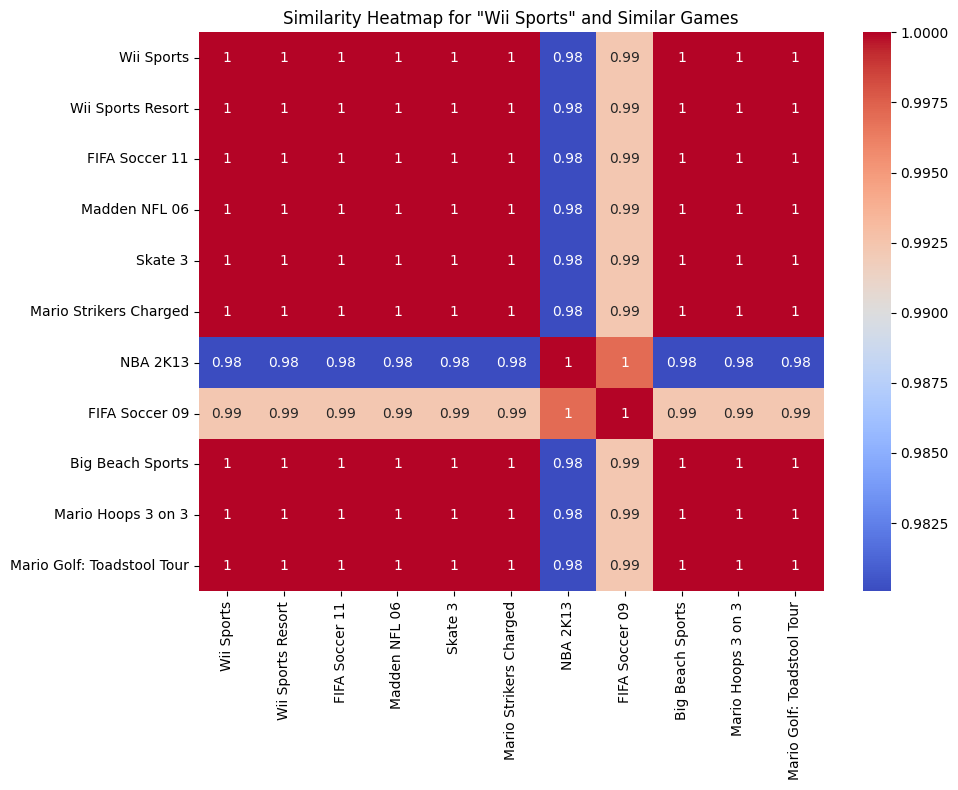

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
file_path = 'Video_Games_Sales_as_at_22_Dec_2016.csv'
df = pd.read_csv(file_path)

# Data Cleaning
# Drop rows with missing 'User_Score' and 'Genre'
df = df.dropna(subset=['User_Score', 'Genre'])
df['User_Score'] = pd.to_numeric(df['User_Score'], errors='coerce')
df = df.dropna(subset=['User_Score'])

# Select relevant features
features_df = df[['Name', 'Genre', 'User_Score']].reset_index(drop=True)

# Encoding categorical feature 'Genre'
encoder = OneHotEncoder(sparse_output=False)
genre_encoded = encoder.fit_transform(features_df[['Genre']])
genre_df = pd.DataFrame(genre_encoded, columns=encoder.get_feature_names_out(['Genre']))

# Combine encoded genre with numeric user score
combined_features = pd.concat([genre_df, features_df[['User_Score']]], axis=1)

# Standardize features to ensure balanced weight
scaler = StandardScaler()
combined_features_scaled = scaler.fit_transform(combined_features)

# Compute cosine similarity matrix
similarity_matrix = cosine_similarity(combined_features_scaled)

# Function to get top 10 similar games
def get_similar_games(game_name, similarity_matrix, features_df):
    try:
        idx = features_df[features_df['Name'] == game_name].index[0]
    except IndexError:
        return f"Game '{game_name}' not found in dataset."

    similarity_scores = list(enumerate(similarity_matrix[idx]))
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)

    top_10_indices = [i[0] for i in similarity_scores[1:11]]
    return features_df.iloc[top_10_indices]

# Example Queries
query_games = ['Wii Sports', 'Mario Kart Wii', 'Call of Duty: Black Ops']

# Collect results
similar_games_results = {}
for query in query_games:
    similar_games_results[query] = get_similar_games(query, similarity_matrix, features_df)

# Display results
for query, similar_games in similar_games_results.items():
    print(f"\nTop 10 games similar to '{query}':")
    print(similar_games)

# Plotting example: Similarity Heatmap for one query
query_idx = features_df[features_df['Name'] == 'Wii Sports'].index[0]
top_indices = [features_df[features_df['Name'] == name].index[0] for name in similar_games_results['Wii Sports']['Name']]
top_indices.insert(0, query_idx)

heatmap_data = similarity_matrix[np.ix_(top_indices, top_indices)]
game_labels = features_df['Name'].iloc[top_indices]

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, xticklabels=game_labels, yticklabels=game_labels, annot=True, cmap='coolwarm')
plt.title('Similarity Heatmap for "Wii Sports" and Similar Games')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()



In [1]:
# ---- Clustering Extension Below ----

# Import libraries
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# STEP 1: Load the datasets
sales_df = pd.read_csv('Video_Games_Sales_as_at_22_Dec_2016.csv')
steam_df = pd.read_csv('steam.csv')

# STEP 2: Clean name columns to improve merging accuracy
sales_df['Name_clean'] = sales_df['Name'].str.lower().str.strip()
steam_df['name_clean'] = steam_df['name'].str.lower().str.strip()

# STEP 3: Merge datasets on game title
merged_df = pd.merge(sales_df, steam_df, left_on='Name_clean', right_on='name_clean', how='inner')
print(f"Merged dataset size: {merged_df.shape[0]} rows")

# STEP 4: Create combined tag column from genres + steamspy_tags + categories
merged_df['combined_tags'] = merged_df[['genres', 'steamspy_tags', 'categories']].fillna('').agg(', '.join, axis=1)

# STEP 5: Apply TF-IDF vectorization with more tag vocabulary
tfidf = TfidfVectorizer(tokenizer=lambda x: x.split(', '), max_features=1000)
tags_vectors = tfidf.fit_transform(merged_df['combined_tags'])

# STEP 6: Print result summary
print("TF-IDF shape:", tags_vectors.shape)
print("\nSample combined tags:")
print(merged_df[['Name', 'combined_tags']].head().to_string(index=False))


Merged dataset size: 1078 rows
TF-IDF shape: (1078, 748)

Sample combined tags:
                         Name                                                                                                          combined_tags
           Grand Theft Auto V Action;Adventure, Open World;Action;Multiplayer, Single-player;Multi-player;Steam Achievements;Full controller support
Grand Theft Auto: San Andreas                                                                   Action, Open World;Action;Multiplayer, Single-player
           Grand Theft Auto V Action;Adventure, Open World;Action;Multiplayer, Single-player;Multi-player;Steam Achievements;Full controller support
  Grand Theft Auto: Vice City                                              Action, Open World;Action;1980s, Single-player;Partial Controller Support
         Grand Theft Auto III                                            Action, Open World;Action;Classic, Single-player;Partial Controller Support


/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


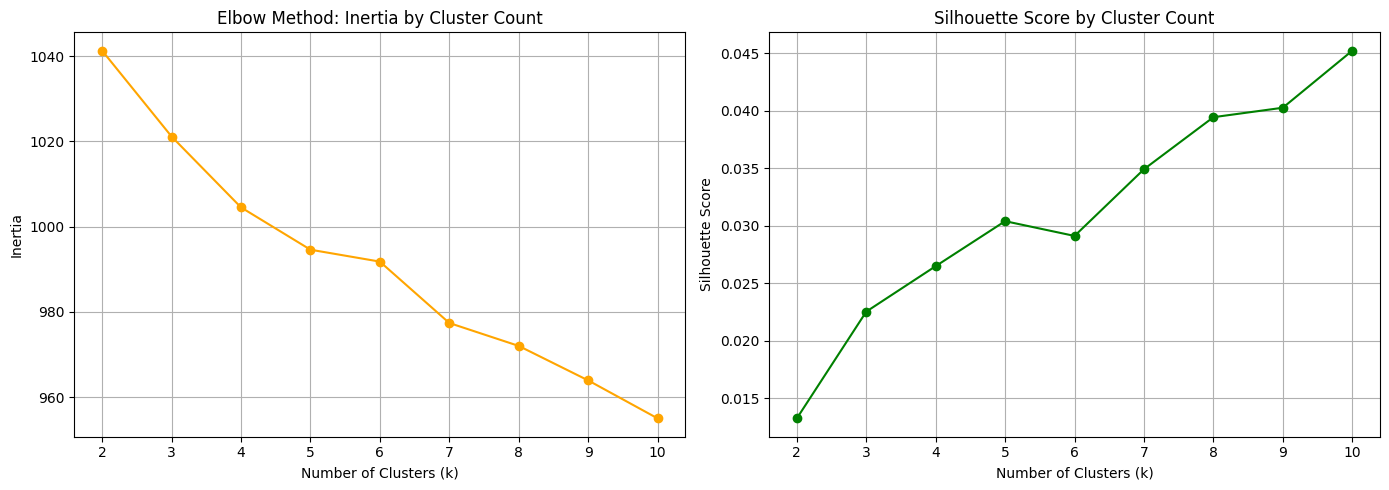

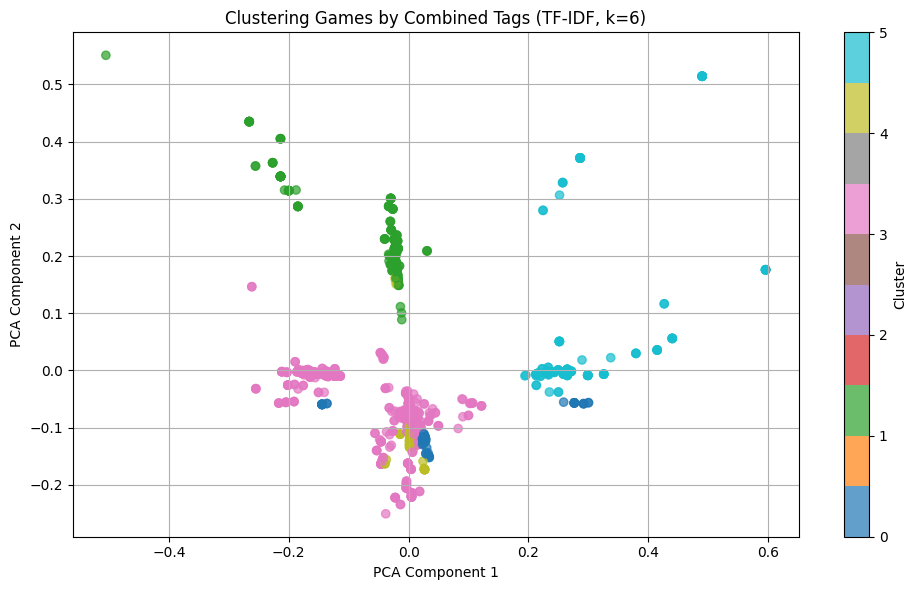

Tag-Based Cluster Summary:
 Cluster  Game Count                                                                                                                                                                                                                                                                                                                                                                                                                                                           Top Tags
       0          53                                                                                                                                                                                                                                                                                                                                 single-player;steam achievements;full controller support;steam trading cards;steam cloud, adventure, action;adventure, action, rpg
       1         165         

In [2]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# ELBOW METHOD + SILHOUETTE SCORES
inertia = []
silhouette_scores = []
k_values = range(2, 11)

for k in k_values:
    model = KMeans(n_clusters=k, random_state=42)
    labels = model.fit_predict(tags_vectors)
    inertia.append(model.inertia_)
    silhouette_scores.append(silhouette_score(tags_vectors, labels))

# PLOT Elbow & Silhouette Score
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Elbow Method
ax[0].plot(k_values, inertia, marker='o', color='orange')
ax[0].set_title('Elbow Method: Inertia by Cluster Count')
ax[0].set_xlabel('Number of Clusters (k)')
ax[0].set_ylabel('Inertia')
ax[0].grid(True)

# Silhouette Scores
ax[1].plot(k_values, silhouette_scores, marker='o', color='green')
ax[1].set_title('Silhouette Score by Cluster Count')
ax[1].set_xlabel('Number of Clusters (k)')
ax[1].set_ylabel('Silhouette Score')
ax[1].grid(True)

plt.tight_layout()
plt.show()

# CHOOSE FINAL K
optimal_k = 6  # Adjust based on elbow results
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42)
final_labels = kmeans_final.fit_predict(tags_vectors)

# Assign cluster labels to merged_df
merged_df['Tag_Cluster'] = final_labels

# PCA REDUCTION FOR VISUALIZATION
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(tags_vectors.toarray())

# SCATTER PLOT
plt.figure(figsize=(10, 6))
scatter = plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], c=final_labels, cmap='tab10', alpha=0.7)
plt.title('Clustering Games by Combined Tags (TF-IDF, k=6)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(scatter, label='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()

# CLUSTER SUMMARY: Top tags per cluster
tag_features_df = pd.DataFrame(tags_vectors.toarray(), columns=tfidf.get_feature_names_out())
tag_features_df['Cluster'] = final_labels

cluster_summary = []
for cluster_id in range(optimal_k):
    cluster_data = tag_features_df[tag_features_df['Cluster'] == cluster_id]
    game_count = cluster_data.shape[0]
    top_tags = cluster_data.drop(columns='Cluster').sum().sort_values(ascending=False).head(5).index.tolist()
    cluster_summary.append({
        'Cluster': cluster_id,
        'Game Count': game_count,
        'Top Tags': ", ".join(top_tags)
    })

summary_df = pd.DataFrame(cluster_summary)

# Show summary table
print("Tag-Based Cluster Summary:")
print(summary_df.to_string(index=False))


In [3]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# (Assume merged_df and tags_vectors already exist and k=6)

# Re-run clustering to get cluster labels
optimal_k = 6
kmeans_optimal = KMeans(n_clusters=optimal_k, random_state=42)
tag_clusters_optimal = kmeans_optimal.fit_predict(tags_vectors)
merged_df['Tag_Cluster'] = tag_clusters_optimal

# Create DataFrame for tags
tag_features_df = pd.DataFrame(tags_vectors.toarray(), columns=tfidf.get_feature_names_out())
tag_features_df['Cluster'] = tag_clusters_optimal

# Summarize each cluster
cluster_summary = []

for cluster_id in range(optimal_k):
    cluster_data = tag_features_df[tag_features_df['Cluster'] == cluster_id]
    game_count = cluster_data.shape[0]
    top_tags = cluster_data.drop(columns='Cluster').sum().sort_values(ascending=False).head(5).index.tolist()
    cluster_summary.append({
        'Cluster': cluster_id,
        'Game Count': game_count,
        'Top Tags': ", ".join(top_tags)
    })

cluster_summary_df = pd.DataFrame(cluster_summary)
print("\nTag-Based Cluster Summary:\n")
print(cluster_summary_df.to_string(index=False))



Tag-Based Cluster Summary:

 Cluster  Game Count                                                                                                                                                                                                                                                                                                                                                                                                                                                           Top Tags
       0          53                                                                                                                                                                                                                                                                                                                                 single-player;steam achievements;full controller support;steam trading cards;steam cloud, adventure, action;adventure, action, rpg
       1         165       

In [4]:
from tabulate import tabulate

print("Tag-Based Cluster Summary:\n")
print(tabulate(cluster_summary_df, headers='keys', tablefmt='grid'))


Tag-Based Cluster Summary:

+----+-----------+--------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|    |   Cluster |   Game Count | Top Tags                                                                                                                                                                                                                                                                                                                                                                                                                                                           